## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tensorflow_probability import edward2 as ed
%matplotlib inline

/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) 

/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andresmasegosa/Google Drive/papers/2019-denmark-pac-bayes/tfp0.7/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be unders

# Data Set

In this first part, we present the data set used for this example. By setting the flag ``MODEL_MISSSPECIFICATION`` we can generate the figures under perfect model specification or under model miss-specification. 

In [2]:
## Learning Method
# 1. PAC^2-Varitional Learning
# 2. PAC^_T2-Varitional Learning

LEARNING_METHOD = 2

## Control the presence of model miss-specficication as shown in Figures 2 and 3. 
MODEL_MISSSPECIFICATION = True



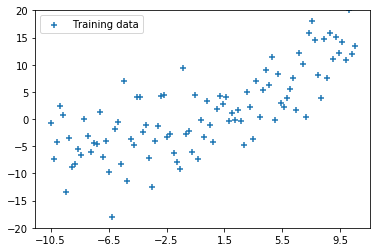

In [3]:
if MODEL_MISSSPECIFICATION:
    VAR=5.
else:
    VAR=1.

if LEARNING_METHOD==1:
    hmaxFlag=False
else:
    hmaxFlag=True
    
# Set seeds for reproducibility
np.random.seed(0)
tf.set_random_seed(0)

NSAMPLE = 100
def sampleData(samples, variance):
    x = np.linspace(-10.5, 10.5, samples).reshape(-1, 1)
    r = 1+np.float32(np.random.normal(size=(samples,1),scale=variance))
    y = np.float32(x*1.0+r*1.0)
    return (x,y)

(x_train, y_train) = sampleData(NSAMPLE, VAR)
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.ylim(-20,20)
plt.xticks(np.arange(-10.5, 10.5, 4))
plt.legend()
plt.show()

# The PAC$^2$-Bayesian Posterior

We now perform learning with the PAC$^2$-Bayesian Posterior computed with the PAC$^2$-Variational algorithm presented in Section 5.1, using a Multivariate Normal (MVN) distribuiton as approximation family. We follow the implementation detailed in Appendix B. 

We now employ Tensorflow Probability and Edward 2 to define and make varitional inference over a Bayesian Linear regression model. Note how in the ``qmodel`` we introduce two MVN distribution with the same variational parameters. 


In [4]:
def model(NSAMPLE):
    W = ed.MultivariateNormalTriL(tf.zeros([1,2]), tf.zeros([2, 2]) + tf.eye(2), name="W")

    x = ed.Normal(loc=tf.zeros([NSAMPLE, 1]), scale=1.0, name="x")

    out = tf.matmul(x, W)[:,0] + tf.matmul(tf.ones(x.shape), W)[:,1]
    out = tf.expand_dims(out,1)
    y = ed.Normal(loc=out, scale=1.0, name="y")

    return W, x, y


def qmodel():
    qmu0 = tf.Variable(tf.random_normal([1,2], 0.0, 0.05, dtype=tf.float32))
    qR = tf.Variable(tf.random_normal([2, 2], 0.0, stddev=0.05, dtype=tf.float32))

    qW = ed.MultivariateNormalTriL(qmu0, qR, name="W")
    qW_ = ed.MultivariateNormalTriL(qmu0, qR, name="W")

    return qW, qW_


W,x,y = model(NSAMPLE)

qW,qW_= qmodel()

with ed.interception(ed.make_value_setter(W=qW,x=x_train,y=y_train)):
    pW,px,py = model(NSAMPLE)

with ed.interception(ed.make_value_setter(W=qW_,x=x_train,y=y_train)):
    pW_,px_,py_ = model(NSAMPLE)



## Defining $\bar{\cal L}_{PB^2}(\rho)$ and $\bar{\cal L}_{PB^2_h}(\rho)$
And, now, we define the functionals $\bar{\cal L}_{PB^2}(\rho)$ and $\bar{\cal L}_{PB^2_h}(\rho)$, as defined in Equations (12) and (20) for computing the posterior $\rho(\theta|D)$ and $\rho_h(\theta|D)$, respectively.

The ``hmaxFlag=True`` computes $\rho_h(\theta|D)$, while ``hmaxFlag=False`` computes $\rho(\theta|D)$. Set the flag and you will be able to see the difference.

In [5]:
logmax = tf.stop_gradient(tf.math.maximum(py.distribution.log_prob(y_train),py_.distribution.log_prob(y_train))+0.1)
logmean = tf.math.reduce_logsumexp(tf.concat([py.distribution.log_prob(y_train),py_.distribution.log_prob(y_train)], 1),axis=1) - tf.log(2.)
inc = tf.expand_dims(logmean,1)-logmax

if (hmaxFlag):
    hmax = 2*tf.stop_gradient(inc/tf.math.pow(1-tf.math.exp(inc),2) + tf.math.pow(tf.math.exp(inc)*(1-tf.math.exp(inc)),-1))
else:
    hmax=1.

var = 0.5*(tf.reduce_sum(tf.exp(2*py.distribution.log_prob(y_train)-2*logmax)*hmax) - tf.reduce_sum(tf.exp(py.distribution.log_prob(y_train) + py_.distribution.log_prob(y_train) - 2*logmax)*hmax))


datalikelihood = tf.reduce_sum(py.distribution.log_prob(py.value))

KL = tf.reduce_sum(qW.distribution.log_prob(qW.value))- \
     tf.reduce_sum(pW.distribution.log_prob(pW.value))

pacelbo = datalikelihood + var - KL



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Optimizing $\bar{\cal L}_{PB^2}(\rho)$ and $\bar{\cal L}_{PB^2_h}(\rho)$

We perform gradient-based optimization of the above objective. 

.


0 epochs	-3553.4133

.

.

.

.

.

.

.

.

.

.


100 epochs	-1548.1333

.

.

.

.

.

.

.

.

.

.


200 epochs	-1317.9795

.

.

.

.

.

.

.

.

.

.


300 epochs	-1469.4363

.

.

.

.

.

.

.

.

.

.


400 epochs	-1401.3629

.

.

.

.

.

.

.

.

.

.


500 epochs	-1398.0846

.

.

.

.

.

.

.

.

.

.


600 epochs	-1407.995

.

.

.

.

.

.

.

.

.

.


700 epochs	-1375.5863

.

.

.

.

.

.

.

.

.

.


800 epochs	-1357.8007

.

.

.

.

.

.

.

.

.

.


900 epochs	-1363.0505

.

.

.

.

.

.

.

.

.

.


1000 epochs	-1342.4569

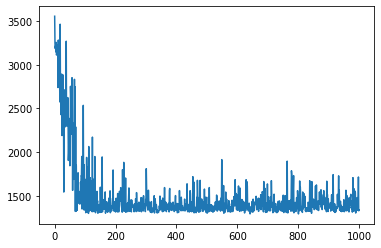

In [6]:
num_epochs=1000
verbose=True
sess = tf.Session()
optimizer = tf.train.AdamOptimizer(0.01)
t = []
train = optimizer.minimize(-pacelbo)
init = tf.global_variables_initializer()
sess.run(init)

for i in range(num_epochs+1):
    t.append(-sess.run(pacelbo))
    sess.run(train)
    if verbose:
        if i % 10 == 0: print(".", end="", flush=True)
        if i % 100 == 0:
            str_elbo = str(-t[-1])
            print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)

plt.plot(t)

## Evaluating the PAC$^2$-Bayesian posterior
Once the model is learned, we evaluate how it makes predictions by ploting its associated epistemic and aleatoric uncertainty

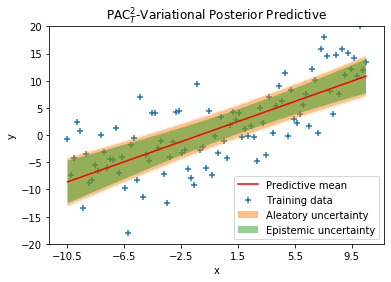

In [7]:
NSAMPLETEST = 10000
(x_test, y_test) = sampleData(NSAMPLETEST, VAR)


with ed.interception(ed.make_value_setter(W=qW,x=x_test)):
    pW,px,py = model(NSAMPLETEST)

#plt.figure(figsize=(8, 8))
y_pred_list = []
y_pred_noise = []

for i in range(100):
    [mean, noise] = sess.run([py.distribution.mean(), py])
    y_pred_list.append(mean)
    y_pred_noise.append(noise)

y_preds = np.concatenate(y_pred_list, axis=1)
y_preds_noise = np.concatenate(y_pred_noise, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

y_sigma_noise = np.std(y_preds_noise, axis=1)

plt.plot(x_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.fill_between(x_test.ravel(),
                 y_mean + 2 * y_sigma_noise,
                 y_mean - 2 * y_sigma_noise,
                 alpha=0.5, label='Aleatory uncertainty')

plt.fill_between(x_test.ravel(),
                 y_mean + 2 * y_sigma,
                 y_mean - 2 * y_sigma,
                 alpha=0.5, label='Epistemic uncertainty')


plt.ylabel('y')
plt.xlabel('x')

plt.ylim(-20,20)
plt.xticks(np.arange(-10.5, 10.5, 4))
plt.legend();

if hmaxFlag:
    plt.title(r'PAC$^2_T$-Variational Posterior Predictive')
else:
    plt.title(r'PAC$^2$-Variational Posterior Predictive')
plt.show()

We also compute the *log-likelihood of the predicitive posterior* over the independent test data set.

In [8]:
y_pred_list = []
for i in range(100):
    y_pred_list.append(sess.run(py.distribution.log_prob(y_test)))

y_preds = tf.concat(y_pred_list, axis=1)

score = tf.reduce_sum(tf.math.reduce_logsumexp(y_preds,axis=1)-tf.log(100.))

score = sess.run(score)

print("\nNegative Log-likelihood of the posterior predictive distribution: "+str(score))


Negative Log-likelihood of the posterior predictive distribution: -69298.22


And we also plot the posterior distribution $\rho(\theta|D)$ or $\rho_h(\theta|D)$

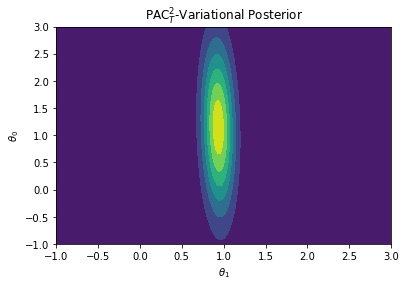

In [9]:
N = 2000
frame=2
X = np.linspace(1.-frame, 1+frame, N)
Y = np.linspace(1.-frame, 1.+frame, N)
X, Y = np.meshgrid(X, Y)



# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z = sess.run(tf.squeeze(qW.distribution.log_prob(tf.expand_dims(np.float32(pos),2))))


# Create a surface plot and projected filled contour plot under it.
plt.contourf(X, Y, np.exp(Z-np.max(Z)))
plt.ylabel(r'$\theta_0$')
plt.xlabel(r'$\theta_1$')

if hmaxFlag:
    plt.title(r'PAC$^2_T$-Variational Posterior')
else:
    plt.title(r'PAC$^2$-Variational Posterior')

plt.show()